# Homework Assignment  5

**Question 1:** Select a directed network, and develop a simple
    link prediction classifier based on the network's directed topology (40pt). 
    Use node or link embedding features and try to improve the classification (20pt)
    
**Bonus:** Evaluate the classifier's ability to predict future links (10pt)
    
** Note:** You can use [Reddit community networks](http://dynamics.cs.washington.edu/data.html), or search
for networks using [The Colorado Index of Complex Networks](https://icon.colorado.edu/).

In [20]:
!pip install turicreate
!pip install networkx
!pip install tqdm
!pip install karateclub

     |████████████████████████████████| 62 kB 513 kB/s 
     |████████████████████████████████| 1.8 MB 41.1 MB/s 
     |████████████████████████████████| 24.1 MB 3.7 MB/s 
     |████████████████████████████████| 50 kB 4.2 MB/s 
  Created wheel for karateclub: filename=karateclub-1.2.3-py3-none-any.whl size=97754 sha256=d9a8d860ebd580c4a1c404ac2d8dc653712acc3a6a4ac0ff9ca88ffd29d5ddaa
  Stored in directory: /root/.cache/pip/wheels/7a/09/80/0d50455fd4e297e88f8f38a711c6f4849e6bd1a330000dde3d
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149857 sha256=8f7eddbd8efd4bbaba6f227f6fd6abc2a19fb7f39c9c7472cd1861b71a521c03
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built karateclub python-Levenshtein
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
! mkdir ./datasets/

In [12]:
!wget --directory-prefix ./datasets/mouseBrain https://s3.amazonaws.com/connectome-graphs/mouse/mouse_brain_1.graphml

--2022-05-01 21:51:38--  https://s3.amazonaws.com/connectome-graphs/mouse/mouse_brain_1.graphml
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.9.125
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.9.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4682122 (4.5M) [binary/octet-stream]
Saving to: ‘./datasets/mouseBrain/mouse_brain_1.graphml’

mouse_brain_1.graph 100%[===================>]   4.46M  --.-KB/s    in 0.08s   

2022-05-01 21:51:38 (52.6 MB/s) - ‘./datasets/mouseBrain/mouse_brain_1.graphml’ saved [4682122/4682122]



In [14]:
!wget --directory-prefix ./datasets/ratBrain https://s3.amazonaws.com/connectome-graphs/rat/rattus.norvegicus_brain_1.graphml

--2022-05-01 21:57:28--  https://s3.amazonaws.com/connectome-graphs/rat/rattus.norvegicus_brain_1.graphml
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.197.104
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.197.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2430425 (2.3M) [binary/octet-stream]
Saving to: ‘./datasets/ratBrain/rattus.norvegicus_brain_1.graphml’

rattus.norvegicus_b 100%[===================>]   2.32M  --.-KB/s    in 0.08s   

2022-05-01 21:57:28 (27.9 MB/s) - ‘./datasets/ratBrain/rattus.norvegicus_brain_1.graphml’ saved [2430425/2430425]



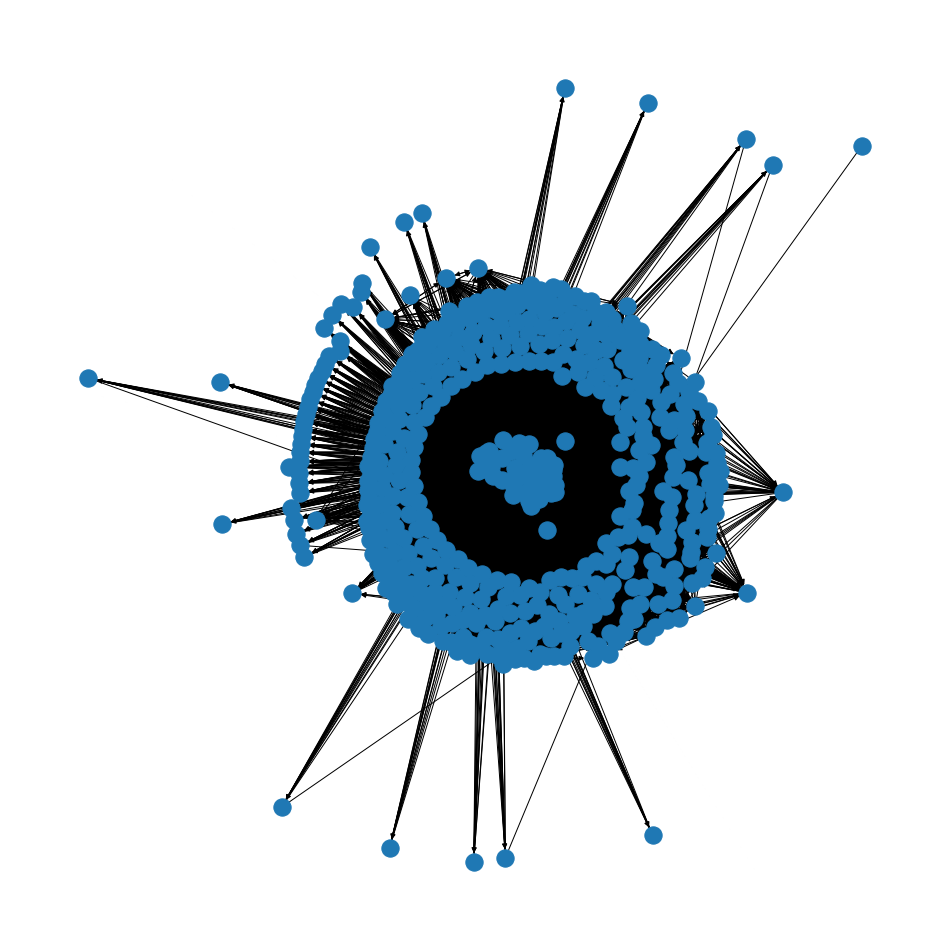

In [16]:
import os
import json
import turicreate as tc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

g_path = "/content/datasets/ratBrain/rattus.norvegicus_brain_1.graphml"

# load dataset
g = nx.read_graphml(g_path)
plt.figure(figsize=(13,13))
nx.draw_kamada_kawai(g)

In [17]:
import random 

def select_random_existing_links(g, n):
    l =list(g.edges())
    random.shuffle(l)
    return l[:n]

def select_random_non_existing_links(g, n):
    select_links = set()
    v_list = list(g.nodes())
    while len(select_links) < n:
        u = random.choice(v_list)
        v = random.choice(v_list)
        if g.has_edge(u,v) or (u,v) in select_links and u == v:
            continue
        else:
            select_links.add((u,v))
    return list(select_links)
            
    
postive_links = select_random_existing_links(g,1000)
negative_links = select_random_non_existing_links(g,1000)

import operator
def find_friends_of_friends(g, v):
    "Returns a set with all the friends of friends of v that are not friends of v"
    friends_set = set(g.neighbors(v))
    friends_of_friends_set = set()
    for f in friends_set:
        friends_of_friends_set |= set(g.neighbors(f))
    friends_of_friends_set -= friends_set
    friends_of_friends_set -= {v}
    return friends_of_friends_set

from tqdm import tqdm_notebook as tqdm 

def friends_measure(g, u,v):
    s = 0
    for x in find_friends_of_friends(g,u):
        for y in find_friends_of_friends(g,v):
            if g.has_edge(x,y) or x == y:
                s += 1
    return s

def common_friends(g,u,v):
    if not g.has_node(u) or not g.has_node(v):
        return None
    return set(g.neighbors(u)) & set(g.neighbors(v))

def total_friends(g, u, v):   
    return len(set(g.neighbors(v)) | set(g.neighbors(u)))

def rank_friends_of_friends(g, v):
    rank_dict = {}
    vertices_set = find_friends_of_friends(g, v)
    for u in vertices_set:
        rank_dict[u] = len(common_friends(g, v, u))
    sorted_d = sorted(rank_dict.items(), key=operator.itemgetter(1), reverse=True)
    return sorted_d

def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            # 'jaccard_coefficient': list(nx.jaccard_coefficient(g,[(u,v)]))[0][2],
            # 'adamic_adar_index': list(nx.adamic_adar_index(g,[(u,v)]))[0][2],
            # 'friends_measure': friends_measure(g, u,v)
        }
    except:
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(g, u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(g, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)

links_features[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:96: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1000 [00:00<?, ?it/s]

{'class': True,
 'common_friends': 46,
 'degree_u': 53,
 'degree_v': 49,
 'total_friends': 56}

In [18]:
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'class']
data_dict = {f:[] for f in features_list}
 

for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)
sf

class,common_friends,degree_u,degree_v,total_friends
1,46,53,49,56
1,50,54,65,69
1,58,495,59,496
1,45,45,79,79
1,9,52,10,53
1,41,44,45,48
1,48,48,49,49
1,44,48,52,56
1,60,61,451,452
1,43,43,446,446


In [19]:
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends']
cls = tc.classifier.create(train,features=features_list, target="class")

Train size 1622
Test size: 378
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 1540

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.005375     | 0.848701          | 0.756098            | 0.559967          | 0.582695            |

| 2         | 0.011033     | 0.847403          | 0.756098            | 0.482144          | 0.527818            |

| 3         | 0.017251     | 0.862338          | 0.792683            | 0.432753          | 0.483628            |

| 4         | 0.024528     | 0.865584          | 0.792683            | 0.399740          | 0.458984            |

| 5         | 0.032113     | 0.868182          | 0.792683            | 0.377744          | 0.441126            |

| 10        | 0.056648     | 0.886364          | 0.829268            | 0.303643          | 0.400505            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 1540

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.003447     | 0.845455          | 0.780488            | 0.400673          | 0.450972            |

| 2         | 0.005582     | 0.842857          | 0.768293            | 0.408459          | 0.455281            |

| 3         | 0.008445     | 0.852597          | 0.817073            | 0.412720          | 0.460420            |

| 4         | 0.010499     | 0.851948          | 0.829268            | 0.409060          | 0.445936            |

| 5         | 0.012739     | 0.856493          | 0.853659            | 0.411248          | 0.436283            |

| 10        | 0.031596     | 0.851299          | 0.804878            | 0.413206          | 0.456079            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 1540

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.003112     | 0.848701          | 0.756098            | 0.397753          | 0.461727            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 1540

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

Number of coefficients    : 5

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.004762     | 0.496753          | 0.524390            |

| 1         | 7        | 2.000000  | 0.015130     | 0.575974          | 0.560976            |

| 2         | 10       | 1.802651  | 0.017696     | 0.637662          | 0.597561            |

| 3         | 20       | 0.006078  | 0.030426     | 0.637662          | 0.597561            |

| 4         | 21       | 0.007598  | 0.033764     | 0.637662          | 0.597561            |

| 9         | 32       | 1.000000  | 0.055451     | 0.637662          | 0.597561            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 1540

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

Number of coefficients      : 5

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.004106     | 0.643506          | 0.597561            |

| 2         | 3        | 0.008209     | 0.690909          | 0.658537            |

| 3         | 4        | 0.012080     | 0.683766          | 0.670732            |

| 4         | 5        | 0.015740     | 0.682468          | 0.646341            |

| 5         | 6        | 0.020461     | 0.681818          | 0.646341            |

| 6         | 7        | 0.025193     | 0.681818          | 0.646341            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.8292682926829268
PROGRESS: RandomForestClassifier          : 0.8048780487804879
PROGRESS: DecisionTreeClassifier          : 0.7560975609756098
PROGRESS: SVMClassifier                   : 0.5975609756097561
PROGRESS: LogisticClassifier              : 0.6463414634146342
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


In [21]:
# convert to undirected
g = g.to_undirected()
l =  zip(g.nodes(), range(len(g.nodes())))
l = list(l)
nodes_dict = dict(l)
r_node_dict = {v:k for k,v in nodes_dict.items()}
list(r_node_dict.items())[:10]
h = nx.Graph()
for e1,e2 in g.edges():
  h.add_edge(nodes_dict[e1], nodes_dict[e2])
print(nx.info(g))
print(nx.info(h))

Graph with 503 nodes and 23030 edges
Graph with 503 nodes and 23030 edges


In [22]:
import karateclub

model = karateclub.DeepWalk()

model.fit(h)
embedding = model.get_embedding()
embedding

import scipy

postive_links = select_random_existing_links(h,1000)
negative_links = select_random_non_existing_links(h,1000)

def distance(u, v):
    # calculates the distance between two nodes
    # by converting theme to their embedded shape
    # and then calculating the distance between the two vectors
    embedded_u = embedding[u]
    embedded_v = embedding[v]
    return scipy.spatial.distance.euclidean(embedded_u,embedded_v)

def get_features_dict(g,u, v):
    removed_edge = False
    if g.has_edge(u,v):
        g.remove_edge(u,v) #  remove edge before feature calculation
        removed_edge = True
    try:
        d = {
            'degree_v': len(list(g.neighbors(v))),
            'degree_u': len(list(g.neighbors(u))),
            'total_friends': total_friends(g,u,v),
            'common_friends': len(common_friends(g,u,v)),
            'embedding_friends': distance(u,v),
        }
    except:
        if removed_edge:
            g.add_edge(u,v) # return the edge back to the graph
        return None

    
    if removed_edge:
        g.add_edge(u,v) # return the edge back to the graph
    return d

links_features = []

for i in tqdm(range(len(postive_links))):    
    u,v = postive_links[i]
    d = get_features_dict(h, u,v )
    if d is None:
        continue
    d['class'] = True
    links_features.append(d)

for i in tqdm(range(len(negative_links))):    
    u,v = negative_links[i]
    d = get_features_dict(h, u,v )
    if d is None:
        continue
    d['class'] = False
    links_features.append(d)

links_features[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1000 [00:00<?, ?it/s]

{'class': True,
 'common_friends': 47,
 'degree_u': 451,
 'degree_v': 48,
 'embedding_friends': 2.562579393386841,
 'total_friends': 452}

In [23]:
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'embedding_friends', 'class']
data_dict = {f:[] for f in features_list}
 

for d in links_features:
    for feature in features_list:
        data_dict[feature].append(d[feature])
sf = tc.SFrame(data_dict)
sf

class,common_friends,degree_u,degree_v,embedding_friends,total_friends
1,47,451,48,2.562579393386841,452
1,76,452,78,4.313167095184326,454
1,71,431,74,4.076251983642578,434
1,48,57,68,1.7268619537353516,77
1,85,317,90,4.340431213378906,322
1,48,49,52,1.0695600509643555,53
1,48,447,49,4.108216285705566,448
1,61,493,62,4.591477394104004,494
1,46,431,47,4.493360996246338,432
1,48,445,49,3.7960007190704346,446


In [24]:
test, train  = sf.random_split(0.2)
print(f"Train size {len(train)}\nTest size: {len(test)}" )
features_list = ['degree_v', 'degree_u', 'total_friends', 'common_friends', 'embedding_friends']
cls = tc.classifier.create(train,features=features_list, target="class")

Train size 1617
Test size: 383
PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: The following methods are available for this type of problem.
PROGRESS: BoostedTreesClassifier, RandomForestClassifier, DecisionTreeClassifier, SVMClassifier, LogisticClassifier
PROGRESS: The returned model will be chosen according to validation accuracy.


Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 1536

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.012476     | 0.985026          | 0.925926            | 0.456994          | 0.488396            |

| 2         | 0.016895     | 0.983724          | 0.938272            | 0.325492          | 0.369667            |

| 3         | 0.021058     | 0.985026          | 0.938272            | 0.242372          | 0.300396            |

| 4         | 0.025263     | 0.986979          | 0.938272            | 0.183881          | 0.251534            |

| 5         | 0.028382     | 0.987630          | 0.950617            | 0.142256          | 0.222796            |

| 10        | 0.067005     | 0.990885          | 0.962963            | 0.052456          | 0.149323            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Random forest classifier:

--------------------------------------------------------

Number of examples          : 1536

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.003353     | 0.972656          | 0.901235            | 0.188984          | 0.291849            |

| 2         | 0.005717     | 0.975260          | 0.938272            | 0.177706          | 0.245528            |

| 3         | 0.008193     | 0.979167          | 0.950617            | 0.177050          | 0.237677            |

| 4         | 0.010440     | 0.983073          | 0.950617            | 0.172978          | 0.232063            |

| 5         | 0.013320     | 0.984375          | 0.938272            | 0.171316          | 0.232330            |

| 10        | 0.025657     | 0.984375          | 0.938272            | 0.170611          | 0.232935            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

Decision tree classifier:

--------------------------------------------------------

Number of examples          : 1536

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| Iteration | Elapsed Time | Training Accuracy | Validation Accuracy | Training Log Loss | Validation Log Loss |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

| 1         | 0.016137     | 0.985026          | 0.925926            | 0.166892          | 0.248100            |

+-----------+--------------+-------------------+---------------------+-------------------+---------------------+

SVM:

--------------------------------------------------------

Number of examples          : 1536

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

Number of coefficients    : 6

Starting L-BFGS

--------------------------------------------------------

+-----------+----------+-----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+-----------+--------------+-------------------+---------------------+

| 0         | 2        | 1.000000  | 0.001346     | 0.499349          | 0.506173            |

| 1         | 4        | 1.000000  | 0.003561     | 0.523438          | 0.530864            |

| 2         | 5        | 1.000000  | 0.005694     | 0.906250          | 0.814815            |

| 3         | 6        | 1.000000  | 0.009279     | 0.871094          | 0.765432            |

| 4         | 12       | 1.033372  | 0.017491     | 0.918620          | 0.839506            |

| 9         | 18       | 1.033372  | 0.033536     | 0.938802          | 0.888889            |

+-----------+----------+-----------+--------------+-------------------+---------------------+

Logistic regression:

--------------------------------------------------------

Number of examples          : 1536

Number of classes           : 2

Number of feature columns   : 5

Number of unpacked features : 5

Number of coefficients      : 6

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training Accuracy | Validation Accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.002794     | 0.938151          | 0.876543            |

| 2         | 3        | 0.007608     | 0.937500          | 0.876543            |

| 3         | 4        | 0.011460     | 0.942708          | 0.888889            |

| 4         | 5        | 0.021364     | 0.952474          | 0.901235            |

| 5         | 6        | 0.025789     | 0.957682          | 0.901235            |

| 8         | 9        | 0.044362     | 0.959635          | 0.901235            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

PROGRESS: Model selection based on validation accuracy:
PROGRESS: ---------------------------------------------
PROGRESS: BoostedTreesClassifier          : 0.9629629629629629
PROGRESS: RandomForestClassifier          : 0.9382716049382716
PROGRESS: DecisionTreeClassifier          : 0.9506172839506173
PROGRESS: SVMClassifier                   : 0.8888888888888888
PROGRESS: LogisticClassifier              : 0.9012345679012346
PROGRESS: ---------------------------------------------
PROGRESS: Selecting BoostedTreesClassifier based on validation set performance.


**Question 2:** Use three different centrality algorithms to identify managers at Enron.
    Evaluate the precision@10 of the algorithms, i.e. how many managers attained the top-10 highest ranks (30pt). Draw 
    the network and visualize one of the centrality measures (10pt)
    

In [3]:
!mkdir datasets
!mkdir ./datasets/enron
!wget -O ./datasets/enron/enron_mail_20150507.tar.gz https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tar.gz
!tar -zxvf ./datasets/enron/enron_mail_20150507.tar.gz -C ./datasets/enron/
!ls ./datasets/enron

Streaming output truncated to the last 5000 lines.
maildir/campbell-l/all_documents/1572.
maildir/campbell-l/all_documents/759.
maildir/campbell-l/all_documents/538.
maildir/campbell-l/all_documents/876.
maildir/campbell-l/all_documents/321.
maildir/campbell-l/all_documents/990.
maildir/campbell-l/all_documents/1842.
maildir/campbell-l/all_documents/1460.
maildir/campbell-l/all_documents/1840.
maildir/campbell-l/all_documents/274.
maildir/campbell-l/all_documents/448.
maildir/campbell-l/all_documents/1692.
maildir/campbell-l/all_documents/400.
maildir/campbell-l/all_documents/224.
maildir/campbell-l/all_documents/188.
maildir/campbell-l/all_documents/1670.
maildir/campbell-l/all_documents/1678.
maildir/campbell-l/all_documents/706.
maildir/campbell-l/all_documents/254.
maildir/campbell-l/all_documents/1429.
maildir/campbell-l/all_documents/1704.
maildir/campbell-l/all_documents/529.
maildir/campbell-l/all_documents/1039.
maildir/campbell-l/all_documents/1694.
maildir/campbell-l/all_doc

In [6]:
# Parsing the Enron dataset. The code may miss some of the links
import os, re
from glob import glob
from tqdm import tqdm_notebook as tqdm 
import networkx as nx
import operator

enron_data_set_path = "./datasets/enron/maildir"

def get_links_from_email(path):
    email_re = re.compile(r"([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
    to_list = []
    from_list = []
    for line in open(path, "r", encoding='utf8', errors='ignore').readlines():
        line = line.strip().lower()
        if line.startswith("to:"):
            to_list = email_re.findall(line)
        if line.startswith("from:"):
            from_list = email_re.findall(line)
    links = set()
    if len(from_list) > 0 and len(to_list) >0:
        for e1 in from_list:
            for e2 in to_list:
                links.add((e1,e2))
    return links          

links = set()
files_list = [p for p in glob(f"{enron_data_set_path}/*/*/*") if "/inbox/" in p or "/sent/" in p]
print("Found %s files" % len(files_list))
for i in tqdm(range(len(files_list))):
    p = files_list[i]              
    if os.path.isfile(p):
        try:
            links |= get_links_from_email(p)
        except:
            continue

g = nx.DiGraph()   
g.add_edges_from(links)
print(nx.info(g))

Found 99279 files


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/99279 [00:00<?, ?it/s]

DiGraph with 18590 nodes and 32392 edges


In [8]:
# algorithm 1 to identify managers at Enron - "community centerality"
import operator
from networkx.algorithms.community import greedy_modularity_communities
cc = greedy_modularity_communities(g.to_undirected())

# add the community each node belong to
for i in range(len(cc)):
    c = cc[i]
    if len(c) < 2:
        continue # skip this community
    for n in c:
        g.nodes[n]['community'] = i 

node_communities_num_dict = {}
for v in g.nodes():
    connected_communities = [g.nodes[u]['community'] for u in g.neighbors(v) if 'community' in g.nodes[u]]
    node_communities_num_dict[v] = len(set(connected_communities))

# Precision@10 evaluation of the algorithms - how many managers attained the top-10 highest ranks
cc_employees = sorted(node_communities_num_dict.items(), key=operator.itemgetter(1), reverse=True)
print("precision@10",cc_employees[:10] )
# -----------------------------------------------------------------------------------------------

precision@10 [('jeff.dasovich@enron.com', 15), ('sara.shackleton@enron.com', 14), ('mark.haedicke@enron.com', 14), ('elizabeth.sager@enron.com', 14), ('mark.taylor@enron.com', 13), ('sally.beck@enron.com', 13), ('tana.jones@enron.com', 13), ('richard.sanders@enron.com', 13), ('susan.scott@enron.com', 13), ('benjamin.rogers@enron.com', 13)]


In [9]:
# algorithm 2 to identify managers at Enron - "degree centerality"
import operator

d_employees = sorted(dict(g.degree()).items(), key=operator.itemgetter(1), reverse=True)

# Precision@10 evaluation of the algorithms - how many managers attained the top-10 highest ranks
print("precision@10",d_employees[:10] )
# -----------------------------------------------------------------------------------------------

precision@10 [('jeff.dasovich@enron.com', 683), ('sara.shackleton@enron.com', 641), ('tana.jones@enron.com', 584), ('gerald.nemec@enron.com', 534), ('kay.mann@enron.com', 471), ('kenneth.lay@enron.com', 466), ('vince.kaminski@enron.com', 434), ('debra.perlingiere@enron.com', 420), ('sally.beck@enron.com', 369), ('jeff.skilling@enron.com', 363)]


In [10]:
# algorithm 3 to identify managers at Enron - "closeness centerality"
all_averages = dict()
for node in g.nodes():
   paths = nx.single_source_shortest_path(g, node)
   num_paths = len(paths)
   agg_length = 0

   for lp in paths.values():
     agg_length += len(lp)

   avg_short_path = agg_length/num_paths
   all_averages[node] = avg_short_path

# Precision@10 evaluation of the algorithms - how many managers attained the top-10 highest ranks
closeness_c = sorted(all_averages.items(), key=operator.itemgetter(1), reverse=True)
print("precision@10",closeness_c[:10] )

precision@10 [('rawsons4@aol.com', 12.195409908418846), ('nwarren@hotmail.com', 12.195409908418846), ('kelmo3@hotmail.com', 12.195409908418846), ('9099632747@airmessage.net', 12.195409908418846), ('westdesksupport@enron.com', 12.195409908418846), ('garrett@jobmenu.com', 12.194285083848191), ('cgallegos@apx.com', 11.198058038177203), ('kourtneynelson@hotmail.com', 11.197947699437272), ('ryan.slinger@enron.com', 11.196645332156256), ('john.anderson@enron.com', 10.199624806885897)]


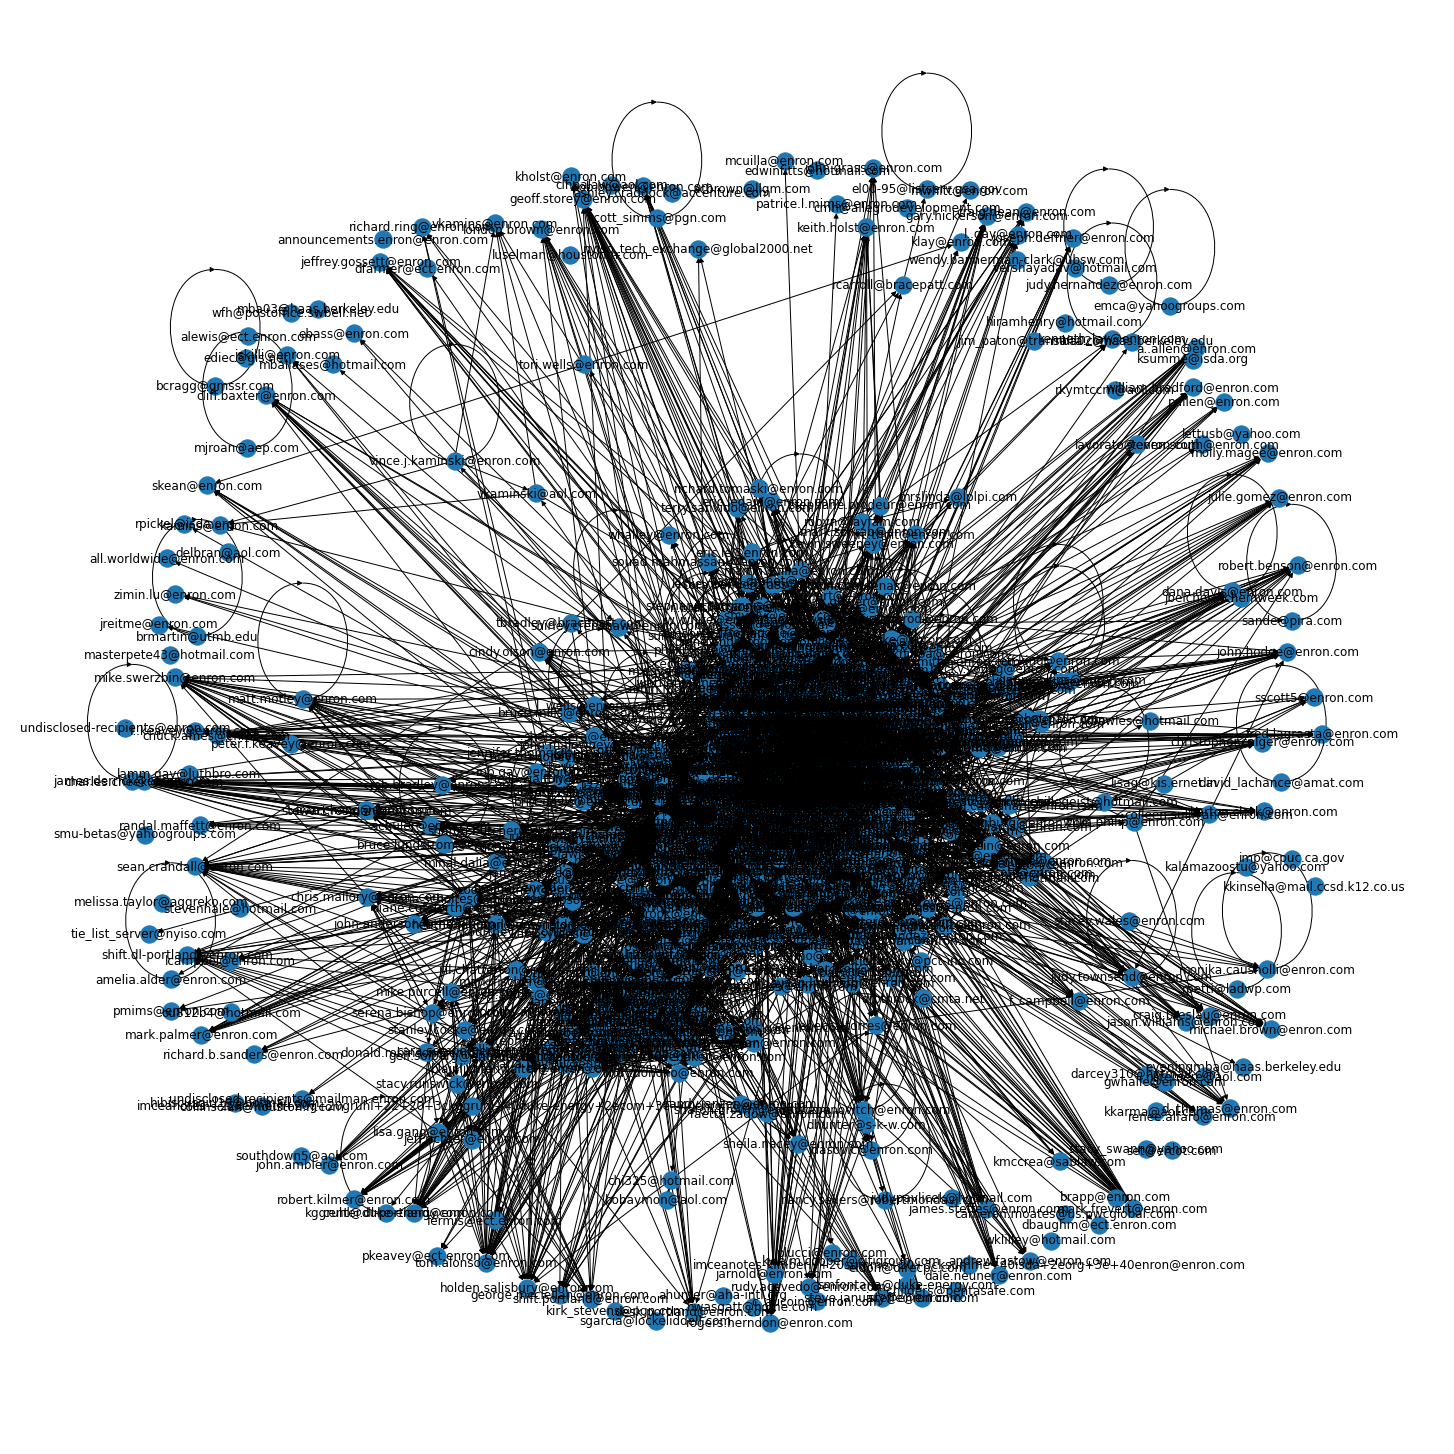

In [11]:
# Draw the network and visualize one of the centrality measures
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Draw the network
l = [n for n,degree in dict(g.degree()).items() if degree > 10]
h = g.subgraph(l)
plt.figure(figsize=(20,20))
nx.draw_spring(h,  with_labels=True)

top ten of each measure
dict_keys(['gerald.nemec@enron.com', 'kay.mann@enron.com', 'kenneth.lay@enron.com', 'vince.kaminski@enron.com', 'debra.perlingiere@enron.com', 'jeff.skilling@enron.com', 'jeff.dasovich@enron.com', 'sara.shackleton@enron.com', 'mark.haedicke@enron.com', 'elizabeth.sager@enron.com'])


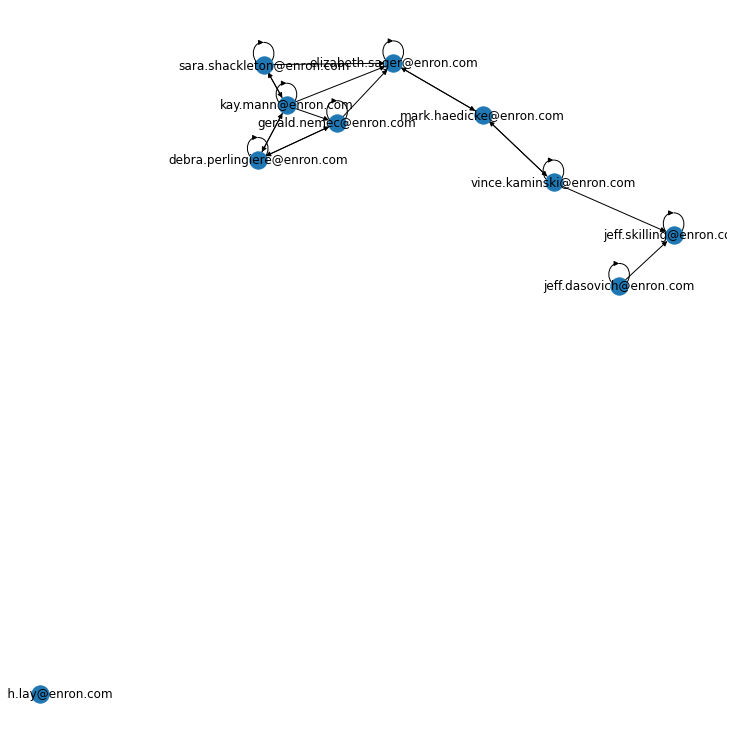

In [14]:
# Visualize top 10
total = []
total.extend(d_employees[:10])
total.extend(closeness_c[:10])
total.extend(cc_employees[:10])
_tdict = dict(total)
_sorted = sorted(_tdict.items(), key=operator.itemgetter(1), reverse=True)
_sorted = _sorted[:10]
_sorted
print("top ten of each measure")
keys = dict(_sorted).keys()
print(keys)
plt.figure(figsize=(10,10))
h = g.subgraph(keys)
nx.draw_spring(h, with_labels=True)

<BarContainer object of 20 artists>

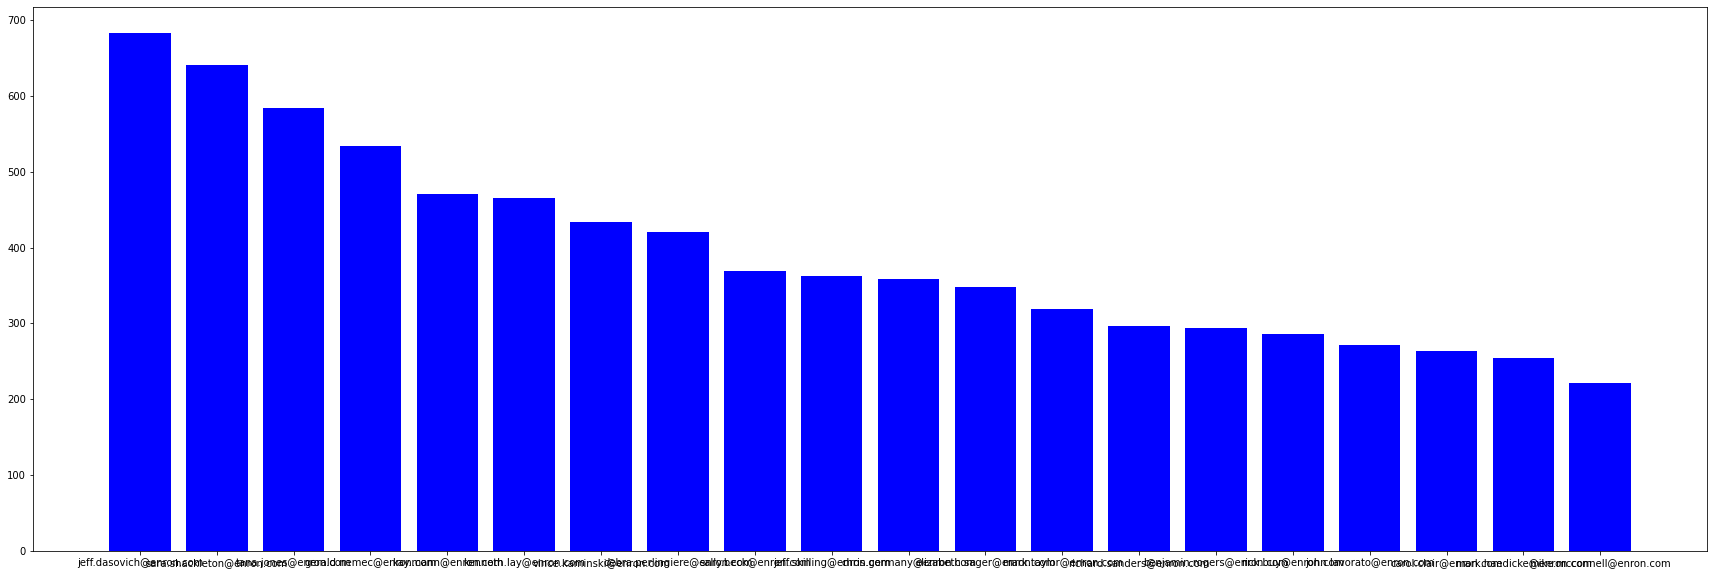

In [18]:
# Visualize one of the centrality measures
myDictionary = dict(d_employees[:20])
plt.figure(figsize=(30,10))
plt.bar(myDictionary.keys(), myDictionary.values(), color='b')
